# COGS 118C Final Project

## Preprocessing

### Setup

In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import scipy
import matplotlib
from scipy.io import wavfile
import picard

### Read Data

In [2]:
sub1_set = 'data/subject1/sub-01_task-songfamiliarity_eeg.set'

# Read the raw data
raw = mne.io.read_raw_eeglab(sub1_set, preload=True)
raw.info

Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject1\sub-01_task-songfamiliarity_eeg.fdt
Reading 0 ... 1807099  =      0.000 ...  1807.099 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FC5, FC1, FCz, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

### Set Electrode Locations

This sets the eletrode locations in the raw file properly.

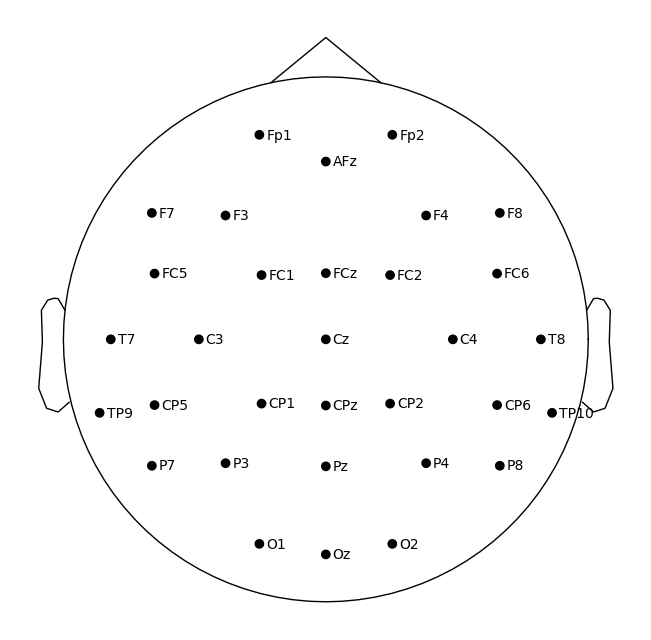

In [3]:
#Setting electrode locations
montage = 'easycap-M1'
file = raw.set_montage(montage)
a = file.plot_sensors(show_names= True)

### Filter Data

We apply a bandpass filter from 0.1 Hz to 50 Hz, since these are the only frequencies we want to analyze.

In [4]:
file_filt = file.filter(0.1, 50, fir_design='firwin')
file_filt.info

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FC5, FC1, FCz, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.1 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

### Reference data to mastoids TP9 and TP10

We re-reference the data to mastoids TP9 and TP10 so that our voltages are all differences from the same references.

In [5]:
file_filt_ref = file_filt.set_eeg_reference(ref_channels=['TP9', 'TP10'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


### Drop mastoids and run ICA on data

Since we won't be analyzing the mastoids, we can drop them. We then run ICA on the data to analyze for artifacts. 
In our final analysis we ended up not using the ICA, however we still include it here for visual purposes.

In [ ]:
components = 0.99
method_p = 'picard'
max_itert = 100
fit_param = dict(fastica_it=5)
random_state_number = 42
ica = mne.preprocessing.ICA(n_components=components, method=method_p, max_iter=max_itert, fit_params=fit_param, random_state=random_state_number)
file_ica = ica.fit(file_filt_ref)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 22 components
Fitting ICA took 26.7s.


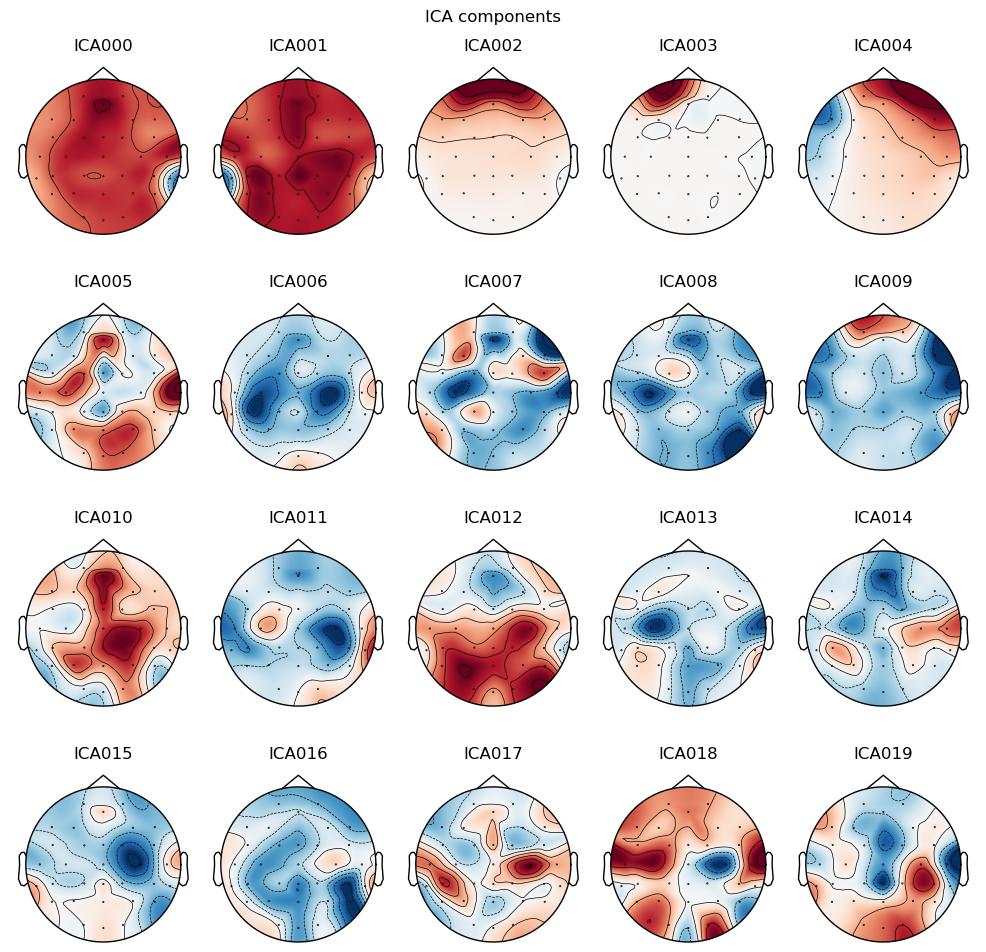

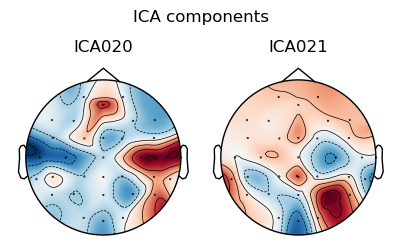

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 390x260.5 with 2 Axes>]

In [ ]:
file_ica.plot_components()

In [ ]:
file_filt_ref.plot()

Using pyopengl with version 3.1.6


<mne_qt_browser._pg_figure.MNEQtBrowser(0x3351dbc00) at 0x33cc24ac0>

Channels marked as bad:
none


/Users/gregoryweber/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()
2025-03-12 17:27:04.654 python[14388:10762703] _TIPropertyValueIsValid called with 16 on nil context!
2025-03-12 17:27:04.654 python[14388:10762703] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-03-12 17:27:04.654 python[14388:10762703] Text input context does not respond to _valueForTIProperty:
2025-03-12 17:35:27.163 python[14388:10762703] _TIPropertyValueIsValid called with 16 on nil context!
2025-03-12 17:35:27.163 python[14388:10762703] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-03-12 17:35:27.163 python[14388:10762703] Text input context does not respond to _valueForTIProperty:


### Saving Data in File

This saves the ICA into its own file.

In [ ]:
file_ica.save('sub01_preprocessed-ica.fif', overwrite=True)

Overwriting existing file.
Writing ICA solution to /Users/gregoryweber/Documents/cogs-118c-song-familiarity/sub01_preprocessed-ica.fif...


Method,picard
Fit parameters,fastica_it=5max_iter=100
Fit,46 iterations on raw data (1807100 samples)
ICA components,22
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


## Data Analysis

### Analyze Recognized Song vs. Noise in One Subject

To start our analysis, we graph a recognized song (Old Mcdonald) in the time domain. 

We decided to plot the electrodes CPz and Cz since they are in the center of the head and associated with recognition.

We also plot the first 10 seconds of EEG data for the same electrodes, as during this time no music is played, and so this is considered noise.

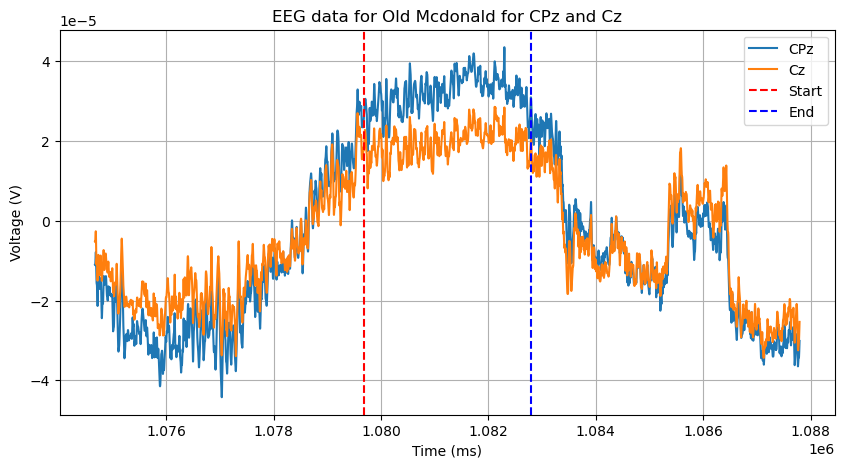

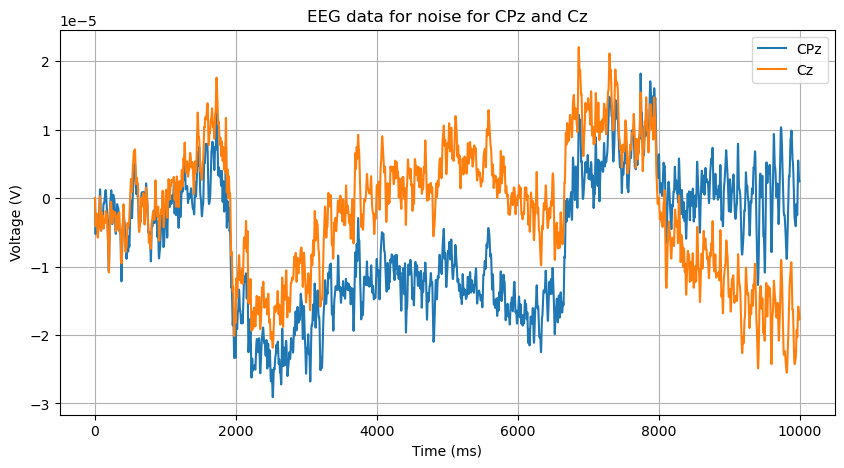

In [ ]:
# graph a recognized song vs noise in time domain
eeg_data, times = file_filt_ref[:, :]
channel_names = file_filt_ref.ch_names

# Get indices for channels CPz and Cz
channels_to_plot = ['CPz', 'Cz']
channel_indices = [channel_names.index(ch) for ch in channels_to_plot]

# Plot the data for CPz and Cz
plt.figure(figsize=(10, 5))
for i in channel_indices:
  start = 1079675
  end = 1082794
  time = np.arange(start - 5000, end + 5000, 1)
  plt.plot(time, eeg_data[i, (start - 5000):(end + 5000)], label=channel_names[i])

# these are the start and stop times for the recognized song "Old Mcdonald"
plt.axvline(x=1079675, color='r', linestyle='--', label='Start')
plt.axvline(x=1082794, color='b', linestyle='--', label='End')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('EEG data for Old Mcdonald for CPz and Cz')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# plot the data for CPz and Cz for noise
plt.figure(figsize=(10, 5))
for i in channel_indices:
  start = 0
  end = 10000
  time = np.arange(start, end, 1)
  plt.plot(time, eeg_data[i, start:end], label=channel_names[i])

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('EEG data for noise for CPz and Cz')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Below are the same two graphs in the frequency domain using Welch's method.

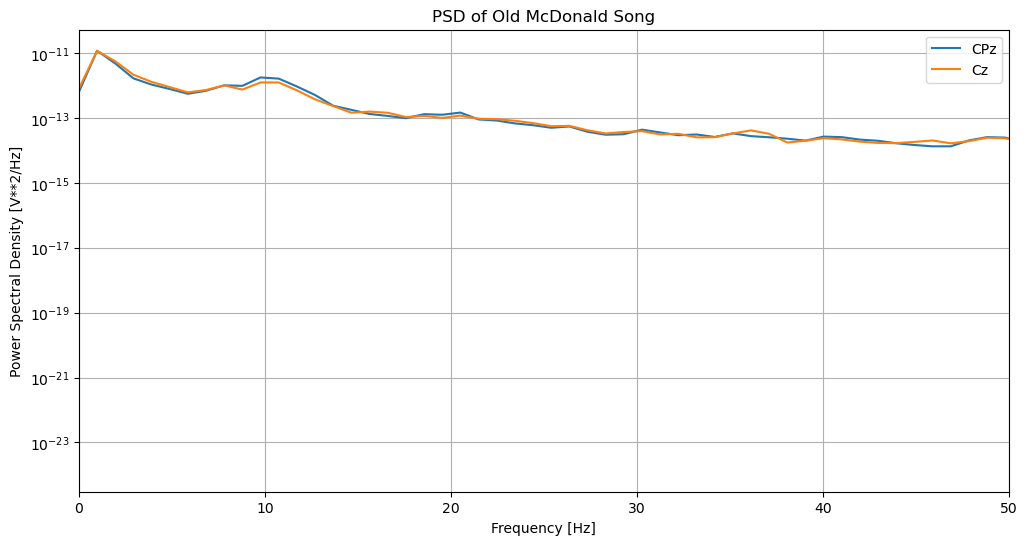

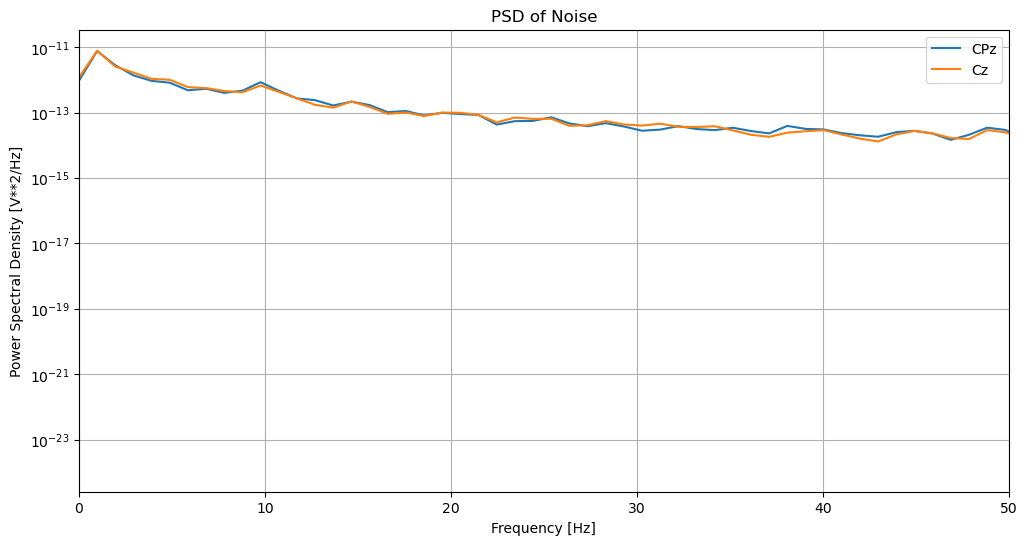

In [ ]:
# graph the power spectral density of a recognized song vs noise
# Calculate PSD for Old McDonald
plt.figure(figsize=(12, 6))
for i in channel_indices:
  start = 1079675
  end = 1082794
  signal = eeg_data[i, (start - 5000):(end + 5000)]
  # calculating the spectral density using Welch's method to reduce variance
  f, Pxx = scipy.signal.welch(signal, fs=1000, nperseg=1024)
  plt.semilogy(f, Pxx, label=channel_names[i])

plt.xlabel('Frequency [Hz]')
plt.xlim([0, 50])
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('PSD of Old McDonald Song')
plt.legend()
plt.grid(True)
plt.show()

# Calculate PSD for noise
plt.figure(figsize=(12, 6))
for i in channel_indices:
  signal = eeg_data[i, 0:10000]
  f, Pxx = scipy.signal.welch(signal, fs=1000, nperseg=1024)
  # use semilogy to plot the power spectral density on a logarithmic scale
  plt.semilogy(f, Pxx, label=channel_names[i])

plt.xlabel('Frequency [Hz]')
plt.xlim([0, 50])
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('PSD of Noise')
plt.legend()
plt.grid(True)
plt.show()

We also do a spectrogram to see what the frequency distribution is over time for both noise and the recognized song.

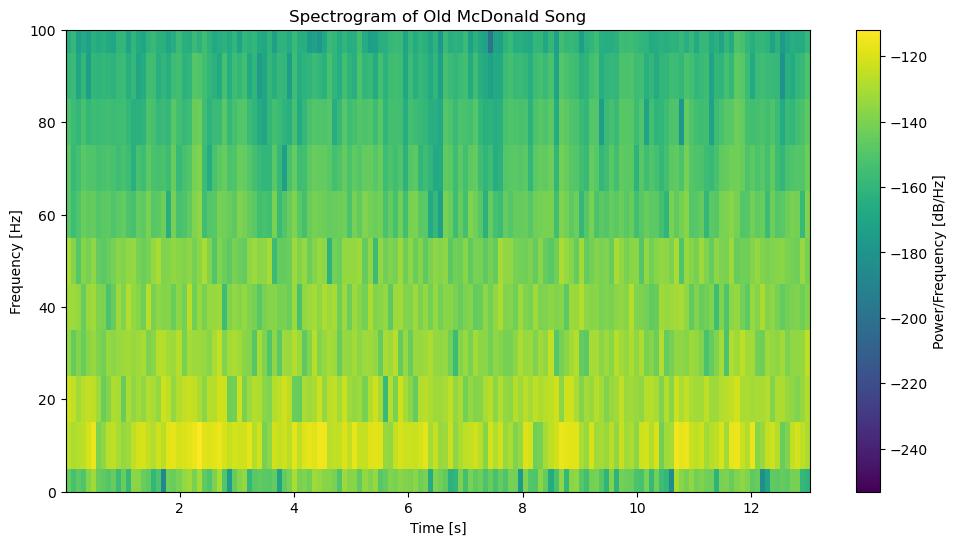

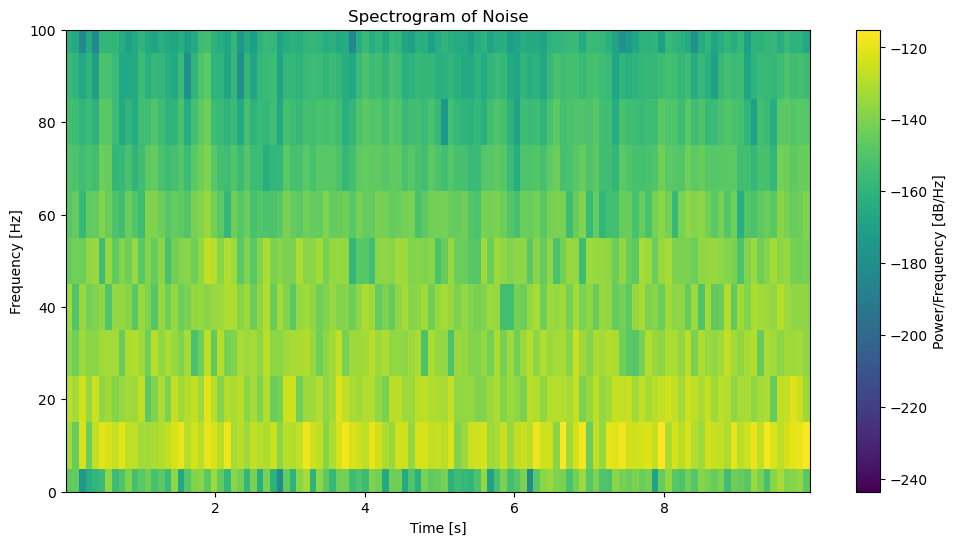

In [ ]:
# do a spectrogram of a recognized song vs noise
# Spectrogram for Old McDonald
plt.figure(figsize=(12, 6))
for i in channel_indices:
  start = 1079675
  end = 1082794
  signal = eeg_data[i, (start - 5000):(end + 5000)]
  # we use nperseg of 100 for more temporal resolution instead of frequency resolution
  f, t, Sxx = scipy.signal.spectrogram(signal, fs=1000, nperseg=100)
  plt.pcolormesh(t, f, 10 * np.log10(Sxx))

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 100])
plt.title('Spectrogram of Old McDonald Song')
plt.colorbar(label='Power/Frequency [dB/Hz]')
plt.show()

# Spectrogram for noise
plt.figure(figsize=(12, 6))
for i in channel_indices:
  signal = eeg_data[i, 0:10000]
  f, t, Sxx = scipy.signal.spectrogram(signal, fs=1000, nperseg=100)
  plt.pcolormesh(t, f, 10 * np.log10(Sxx))

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 100])
plt.title('Spectrogram of Noise')
plt.colorbar(label='Power/Frequency [dB/Hz]')
plt.show()

### Analyze Recognized Song vs. Unrecognized Song

Here we take 15 recognized songs by the participant and mark their start times in the data. We then average out 10 seconds from the start time of each song and plot in the time domain. We also take the FFT of the first 10 seconds of each song and take an average to plot the recognized songs in the frequency domain.

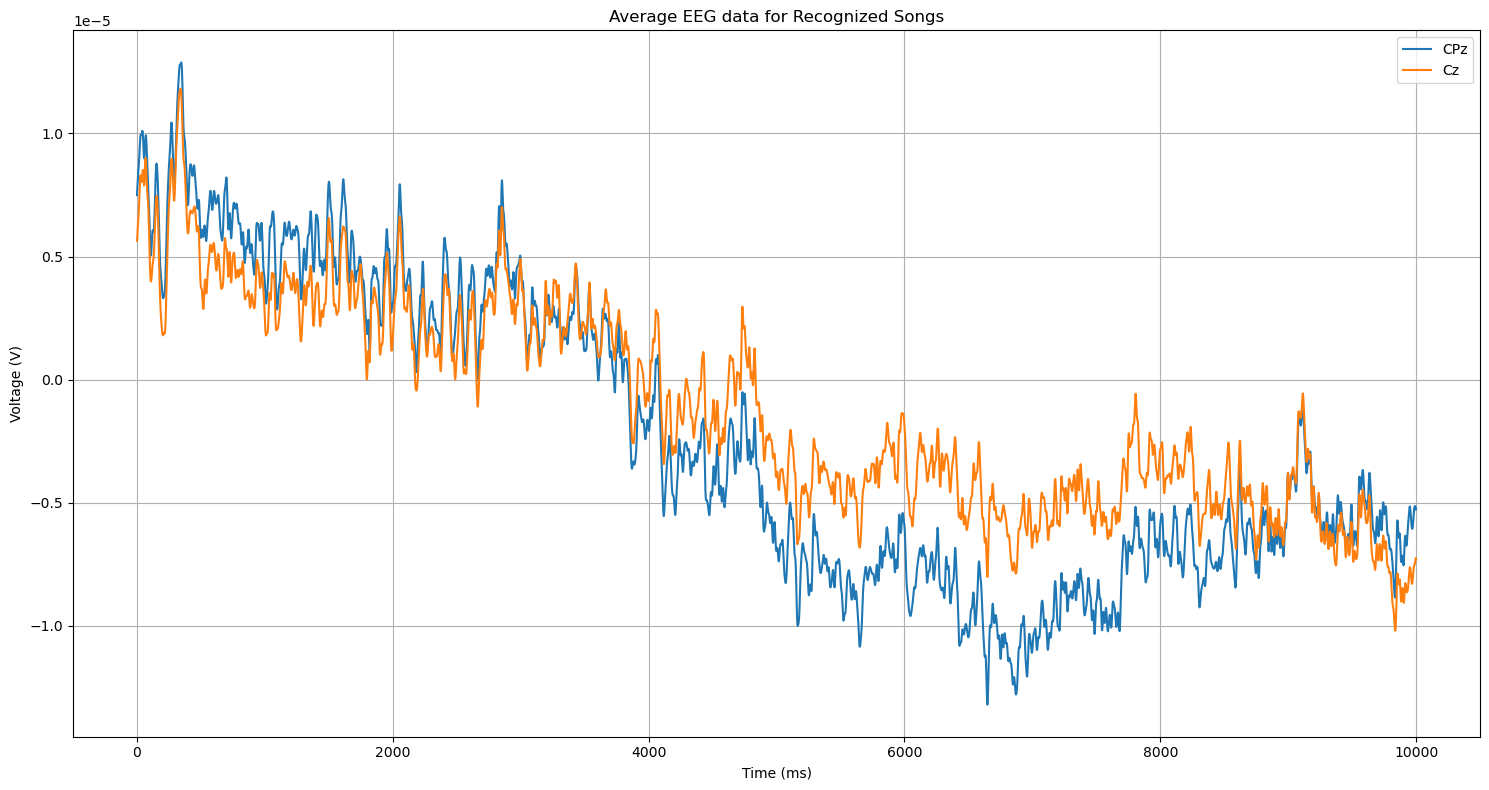

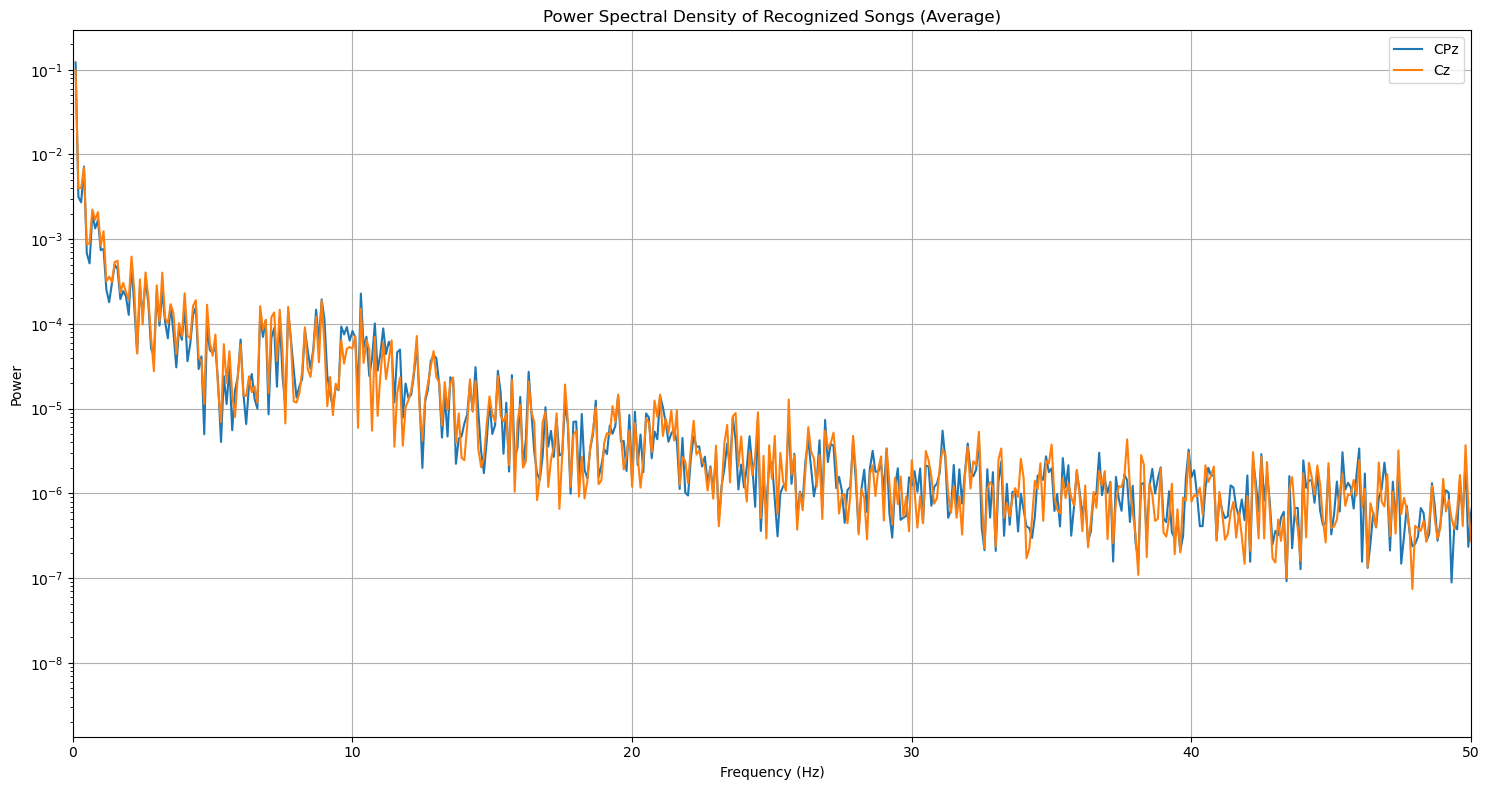

In [13]:
# Take 10 recognized songs in subject 1 and average the data

# 1. she'll be coming around the mountain
# 2. hickory dickory dock
# 3. pop goes the weasel
# 4. YMCA
# 5. mickey mouse march
# 6. eye of the tiger
# 7. yankee doodle
# 8. star spangled banner
# 9. let it snow
# 10. row your boat
# 11. old mcdonald
# 12. Billie Jean
# 13. another one bites the dust
# 14. star spangled banner
# 15. rock a bye baby
sub1_recognized_song_times = [203429, 229869, 270495, 360080, 664854, 957749, 1369273, 1319672, 1502496, 1079675, 1181075, 1617377, 1445916, 451150]

# Initialize array to store averaged data
average_recognized = np.zeros((len(file_filt_ref.ch_names), 10000))  # 10 seconds at 1000Hz
average_freq = np.zeros((len(file_filt_ref.ch_names), 10000))

# For each recognized song time
for time in sub1_recognized_song_times:
  start = time
  end = time + 10000
  data, times = file_filt_ref[:, start:end]
  average_recognized += data
  average_freq += np.abs(np.fft.fft(average_recognized)) ** 2

# Average across all songs
average_recognized /= len(sub1_recognized_song_times)
average_freq /= len(sub1_recognized_song_times)

plt.figure(figsize=(15, 8))
for i in channel_indices:
  plt.plot(np.arange(10000), average_recognized[i], label=channel_names[i])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('Average EEG data for Recognized Songs')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculate FFT
frequencies = np.fft.fftfreq(len(average_recognized[0]), 1/1000)
fft_data = np.fft.fft(average_recognized)
fft_data = np.abs(fft_data)**2

# Plot FFT for all channels
plt.figure(figsize=(15, 8))
for i in channel_indices:
  plt.plot(frequencies[frequencies > 0], average_freq[i, frequencies > 0], label=channel_names[i])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectral Density of Recognized Songs (Average)')
plt.yscale('log')
plt.xlim([0, 50])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='upper right')
plt.tight_layout()

We also do the same process for 10 unrecognized songs to compare vs. the recognized songs.

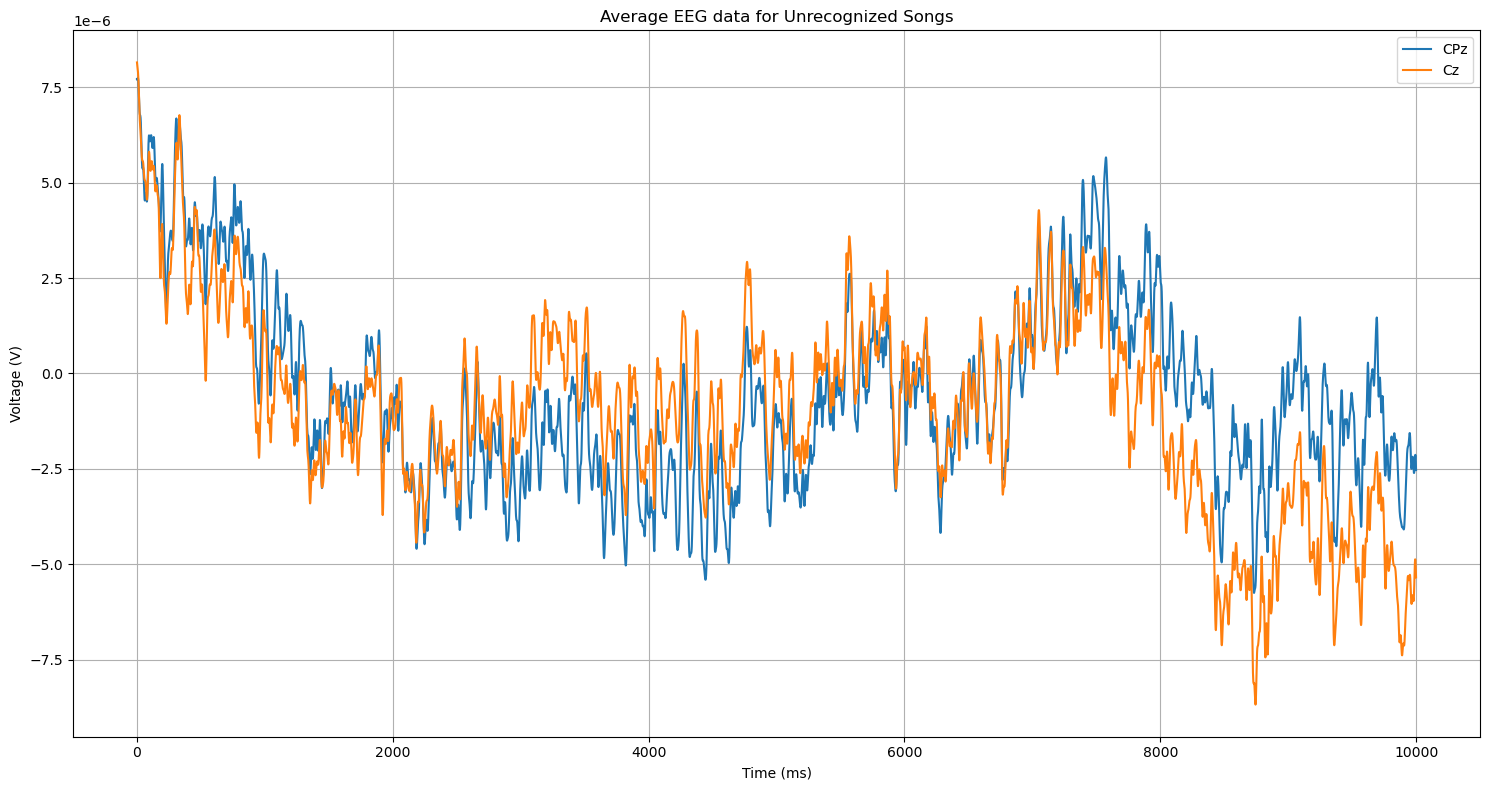

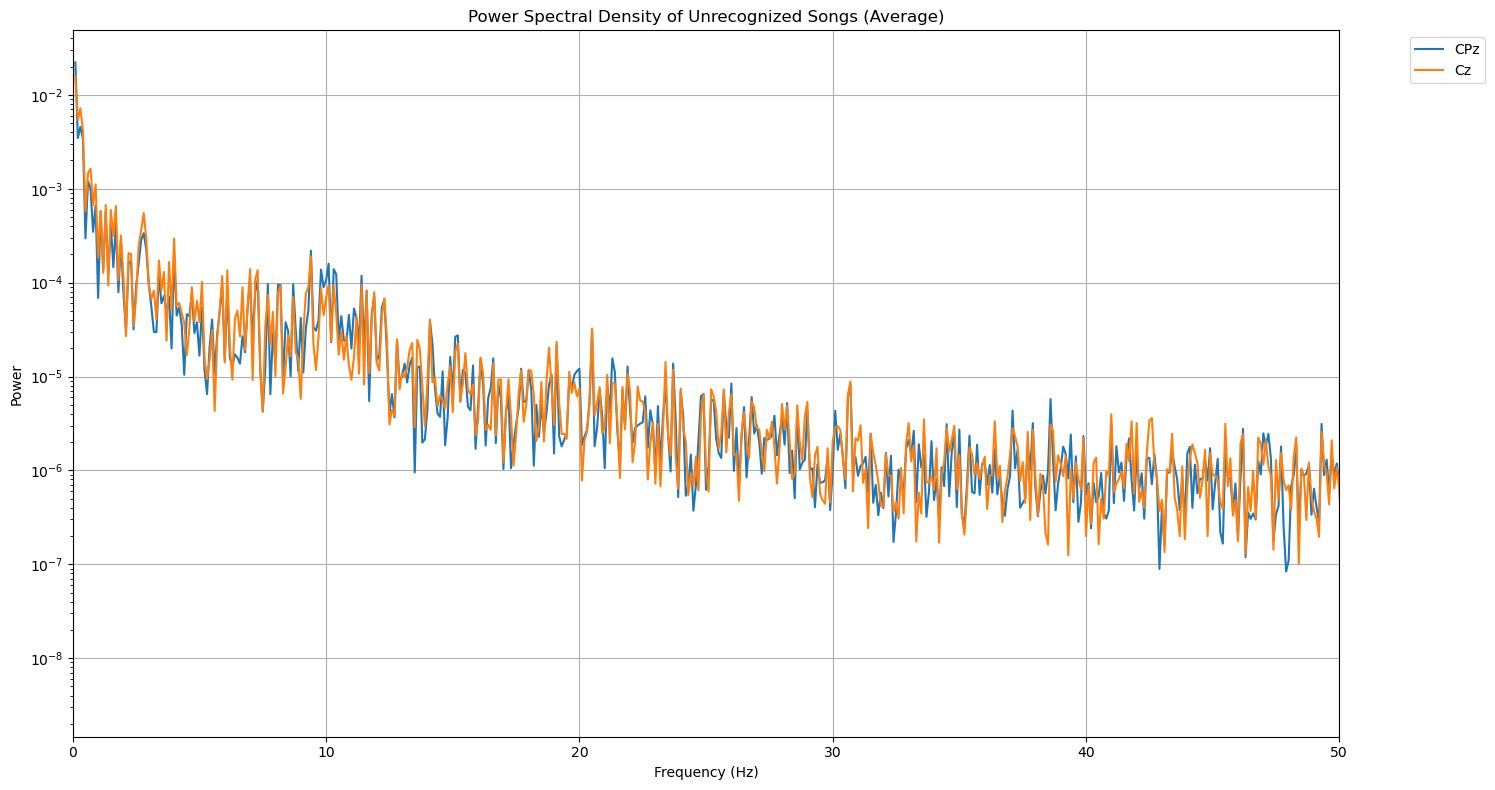

In [12]:
# Take 10 unrecognized songs in subject 1 and average the data

sub1_unrecognized_song_times = [73709, 103303, 125940, 181721, 313689, 338190, 396576, 500415, 529502, 592323, 683276, 704556, 727896, 745621, 767959]

# Initialize array to store averaged data
average_unrecognized = np.zeros((len(file_filt_ref.ch_names), 10000))  # 10 seconds at 1000Hz
average_freq = np.zeros((len(file_filt_ref.ch_names), 10000))

# For each recognized song time
for time in sub1_unrecognized_song_times:
  start = time
  end = time + 10000
  data, times = file_filt_ref[:, start:end]
  average_unrecognized += data
  average_freq += np.abs(np.fft.fft(average_unrecognized)) ** 2

# Average across all songs
average_unrecognized /= len(sub1_unrecognized_song_times)
average_freq /= len(sub1_unrecognized_song_times)

plt.figure(figsize=(15, 8))
for i in channel_indices:
  plt.plot(np.arange(10000), average_unrecognized[i], label=channel_names[i])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('Average EEG data for Unrecognized Songs')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculate FFT
frequencies = np.fft.fftfreq(len(average_unrecognized[0]), 1/1000)
fft_data = np.fft.fft(average_unrecognized)
fft_data = np.abs(fft_data)**2

# Plot FFT for all channels
plt.figure(figsize=(15, 8))
for i in channel_indices:
  plt.plot(frequencies[frequencies > 0], average_freq[i, frequencies > 0], label=channel_names[i])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectral Density of Unrecognized Songs (Average)')
plt.yscale('log')
plt.xlim([0, 50])
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()